# Roll Balance and Chassis Equations


### Sources:
 - Racecar Vehicle Dynamics - w. Miliken & D. Miliken
 - Roll Centres and Jacking Forces in Independent Suspensions A First Principles Explanation and a Designer's Toolkit - M. B. Gerrard
 - The Effect of Chassis Stiffness on Race Car Handling Balance - A. Deakin et. al.

In [6]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from IPython.display import display, Markdown
import sympy

# Wrapper function for easily displaying markdown text
disp_md = lambda text: display(Markdown(text))


<h2> Symbolically set up load transfer equations

In [7]:
total_load_transfer_symb, load_transfer_front_symb, load_transfer_rear_symb  = sympy.symbols('LT LT_f LT_r')
roll_stiffness_front_symb, roll_stiffness_rear_symb, chassis_stiffness_symb, lateral_acceleration_symb = sympy.symbols('K_f K_r K_ch a_c')
track_symb, center_of_mass_height_symb, RCH_f_symb, RCH_r_symb = sympy.symbols('T H_cg RCH_f RCH_r')
mass_symb, mass_front_symb, mass_rear_symb = sympy.symbols('m m_f m_r')

phi_1_symb, phi_2_symb, front_inertial_moment_symb, rear_inertial_moment_symb, avg_wheel_travel_symb = sympy.symbols('phi_1 phi_2 M_f M_r ΔW')
f_lt_ratio_symb, f_roll_spring_ratio_symb, r_mass_ratio_symb, chassis_tuning_constant_symb, lt_to_acceleration_ratio_symb, roll_center_diff_symb = sympy.symbols('η λ γ κ ξ δ')


front_moment_balance = sympy.Eq(front_inertial_moment_symb, roll_stiffness_front_symb*phi_1_symb - chassis_stiffness_symb*(phi_2_symb-phi_1_symb))
rear_moment_balance = sympy.Eq(rear_inertial_moment_symb, roll_stiffness_rear_symb*phi_2_symb + chassis_stiffness_symb*(phi_2_symb-phi_1_symb))

disp_md('## Moment Balance Equations:')
display(front_moment_balance)
display(rear_moment_balance)

chassis_tuning_eq = sympy.Eq(chassis_tuning_constant_symb**-1, (f_roll_spring_ratio_symb-1)*(f_lt_ratio_symb+1)/((f_lt_ratio_symb-1)*(f_roll_spring_ratio_symb+1))) #This inverse doesn't match my notes but it seems to give better results
disp_md('## Chassis Tuning Constant Equation:')
display(chassis_tuning_eq)

wheel_travel_equation = sympy.Eq(avg_wheel_travel_symb, track_symb/2 * (phi_1_symb+phi_2_symb)/2)
disp_md('## Average Wheel Travel In Roll Equation:')
display(wheel_travel_equation)

roll_angles = sympy.solve([front_moment_balance, rear_moment_balance], [phi_1_symb, phi_2_symb])
load_transfer_equations = [sympy.Eq(roll_stiffness_front_symb*roll_angles[phi_1_symb]/track_symb, load_transfer_front_symb), 
                           sympy.Eq(roll_stiffness_rear_symb*roll_angles[phi_2_symb]/track_symb, load_transfer_rear_symb), 
                           chassis_tuning_eq,
                           wheel_travel_equation.subs(roll_angles)]

disp_md('## Load Transfer System of Equations:')
display(*load_transfer_equations)


#total_load_transfer = 2*mass*ac*h/t

substitution_expressions = [(roll_stiffness_front_symb, f_roll_spring_ratio_symb*roll_stiffness_rear_symb), 
        
        (front_inertial_moment_symb, mass_front_symb*lateral_acceleration_symb * (center_of_mass_height_symb-RCH_f_symb)), 
        (rear_inertial_moment_symb, mass_rear_symb*lateral_acceleration_symb * (center_of_mass_height_symb-RCH_r_symb)), 


        (load_transfer_front_symb, load_transfer_rear_symb* f_lt_ratio_symb), 
        (load_transfer_rear_symb, total_load_transfer_symb/(1+f_lt_ratio_symb)),

        (mass_front_symb, (1-r_mass_ratio_symb)*mass_symb), 
        (mass_rear_symb, r_mass_ratio_symb*mass_symb),

        (total_load_transfer_symb, lt_to_acceleration_ratio_symb*lateral_acceleration_symb),


        (RCH_f_symb, RCH_r_symb+roll_center_diff_symb)
        ]

nondim_equations = [expr.subs(substitution_expressions).simplify() for expr in load_transfer_equations]

disp_md('## Nondim Load Transfer Equations:')
display(*nondim_equations)


## Moment Balance Equations:

Eq(M_f, -K_ch*(-phi_1 + phi_2) + K_f*phi_1)

Eq(M_r, K_ch*(-phi_1 + phi_2) + K_r*phi_2)

## Chassis Tuning Constant Equation:

Eq(1/κ, (η + 1)*(λ - 1)/((η - 1)*(λ + 1)))

## Average Wheel Travel In Roll Equation:

Eq(ΔW, T*(phi_1 + phi_2)/4)

## Load Transfer System of Equations:

Eq(K_f*(K_ch*M_f + K_ch*M_r + K_r*M_f)/(T*(K_ch*K_f + K_ch*K_r + K_f*K_r)), LT_f)

Eq(K_r*(K_ch*M_f + K_ch*M_r + K_f*M_r)/(T*(K_ch*K_f + K_ch*K_r + K_f*K_r)), LT_r)

Eq(1/κ, (η + 1)*(λ - 1)/((η - 1)*(λ + 1)))

Eq(ΔW, T*((K_ch*M_f + K_ch*M_r + K_f*M_r)/(K_ch*K_f + K_ch*K_r + K_f*K_r) + (K_ch*M_f + K_ch*M_r + K_r*M_f)/(K_ch*K_f + K_ch*K_r + K_f*K_r))/4)

## Nondim Load Transfer Equations:

Eq(a_c*η*ξ/(η + 1), a_c*m*λ*(K_ch*γ*(H_cg - RCH_r) + K_ch*(γ - 1)*(-H_cg + RCH_r + δ) + K_r*(γ - 1)*(-H_cg + RCH_r + δ))/(T*(K_ch*λ + K_ch + K_r*λ)))

Eq(a_c*ξ/(η + 1), a_c*m*(K_ch*γ*(H_cg - RCH_r) + K_ch*(γ - 1)*(-H_cg + RCH_r + δ) + K_r*γ*λ*(H_cg - RCH_r))/(T*(K_ch*λ + K_ch + K_r*λ)))

Eq(1/κ, (η + 1)*(λ - 1)/((η - 1)*(λ + 1)))

Eq(ΔW, T*a_c*m*(2*K_ch*γ*(H_cg - RCH_r) + 2*K_ch*(γ - 1)*(-H_cg + RCH_r + δ) + K_r*γ*λ*(H_cg - RCH_r) + K_r*(γ - 1)*(-H_cg + RCH_r + δ))/(4*K_r*(K_ch*λ + K_ch + K_r*λ)))

<h3>Initial Ride Rate Calculations</h3>

Non ground effect Indy Cars ran 95-120cpm(1.58-2.0000Hz ) which seems like a good place to start - RCVD 16.2

To insure initial understeer, calculate the Total Lateral
Load Transfer Distribution (TLLTD) to be 5% more than
the weight distribution at the front - RCVD table 16.5

In [8]:
g = 9.81 #m/s^2

f = 2.2 # Hz

# vehicle parameters as a dictionary
vehicle_params = {
    'wheelbase': 1530e-3, # m
    'track_width': 1300e-3, # m Measured off last years car
    'center_of_mass_height': 270e-3, # m From Rough_Asm solidworks model
    'unsprung_mass': 230, # kg
    'rear_mass_ratio': 0.57, # From Rough_Asm solidworks model
    'total_wheel_travel': 33e-3, # m
    'target_frequency': f*2*np.pi, # rad/s
    'roll_travel_ratio': 0.60, # fraction of wheel travel used in roll
    'maximum_lateral_acceleration': 1.3 * 9.81, # m/s^2
    'front_load_transfer_ratio': 1.05, # slightly higher front load transfer is to give margin for understeer
    'chassis_tuning_constant': 0.80, # ratio of how a change in roll stiffness balance affects the load transfer balance
    'roll_center_diff': -40e-3 # m
}

# Display vehicle parameters as a markdown table
def vehicle_params_table(params):
    table = "| Parameter | Value |\n|---|---|\n"
    for k, v in params.items():
        try:
            val = f"{v:.4g}" if isinstance(v, float) else str(v)
        except Exception:
            val = str(v)
        table += f"| {k} | {val} |\n"
    return table

disp_md("## Vehicle Parameters")
disp_md('All units are in SI')
disp_md(vehicle_params_table(vehicle_params))

# unpack for convenience
wheelbase = vehicle_params['wheelbase']
track_width = vehicle_params['track_width']
total_wheel_travel = vehicle_params['total_wheel_travel']
unsprung_mass = vehicle_params['unsprung_mass']
rear_mass_ratio = vehicle_params['rear_mass_ratio']
center_of_mass_height = vehicle_params['center_of_mass_height']
target_frequency = vehicle_params['target_frequency']
roll_travel_ratio = vehicle_params['roll_travel_ratio']
maximum_lateral_acceleration = vehicle_params['maximum_lateral_acceleration']
front_load_transfer_ratio = vehicle_params['front_load_transfer_ratio']
chassis_tuning_constant = vehicle_params['chassis_tuning_constant']
roll_center_diff = vehicle_params['roll_center_diff']

rear_wheel_ride_rate = (unsprung_mass*rear_mass_ratio/2) * target_frequency**2
print((rear_wheel_ride_rate/90)**(1/2) / (2*np.pi))
disp_md(f'The ideal individual *rear* wheel ride rate with an undamped natural frequency of {f} Hz is **{rear_wheel_ride_rate*1e-3 :.2f} N/mm**  [{5.7101471627692*rear_wheel_ride_rate*1e-3 :.2f} lb/in]')

front_wheel_ride_rate = (unsprung_mass*(1-rear_mass_ratio)/2) * target_frequency**2
disp_md(f'The ideal individual *front* wheel ride rate with an undamped natural frequency of {f} Hz is **{front_wheel_ride_rate*1e-3 :.2f} N/mm**  [{5.7101471627692*front_wheel_ride_rate*1e-3 :.2f} lb/in]')


bottom_out_acc =  (2*rear_wheel_ride_rate*total_wheel_travel) / (unsprung_mass * rear_mass_ratio)
disp_md(f'The rear suspension will bottom out under a bump of **{bottom_out_acc/g :.3g} gs**  [{bottom_out_acc :.3g} m/s^2]')

## Vehicle Parameters

All units are in SI

| Parameter | Value |
|---|---|
| wheelbase | 1.53 |
| track_width | 1.3 |
| center_of_mass_height | 0.27 |
| unsprung_mass | 230 |
| rear_mass_ratio | 0.57 |
| total_wheel_travel | 0.033 |
| target_frequency | 13.82 |
| roll_travel_ratio | 0.6 |
| maximum_lateral_acceleration | 12.75 |
| front_load_transfer_ratio | 1.05 |
| chassis_tuning_constant | 0.8 |
| roll_center_diff | -0.04 |


1.8775338434588427


The ideal individual *rear* wheel ride rate with an undamped natural frequency of 2.2 Hz is **12.53 N/mm**  [71.52 lb/in]

The ideal individual *front* wheel ride rate with an undamped natural frequency of 2.2 Hz is **9.45 N/mm**  [53.95 lb/in]

The rear suspension will bottom out under a bump of **0.643 gs**  [6.31 m/s^2]

<h3> Front ARB and chassis stiffness </h3>

In [9]:
rear_roll_stiffness = track_width**2 * rear_wheel_ride_rate / 2 
variable_values = [
    (track_symb, track_width), 
    (center_of_mass_height_symb, center_of_mass_height), 
    (mass_symb, unsprung_mass),
    (roll_stiffness_rear_symb, rear_roll_stiffness),
    (avg_wheel_travel_symb, total_wheel_travel*roll_travel_ratio),
    (f_lt_ratio_symb, front_load_transfer_ratio),
    (r_mass_ratio_symb, rear_mass_ratio), 
    (roll_center_diff_symb, roll_center_diff), 
    (chassis_tuning_constant_symb, chassis_tuning_constant),  #ratio of how a change in roll stiffness balance affects the load transfer balance
    (lateral_acceleration_symb, maximum_lateral_acceleration),
]

disp_md('## Roll Balance Parameters')
table = "| Parameter | Value |\n|---|---|\n" + "".join([f"| {eq[0]} | {eq[1] : .3f} |\n" for eq in variable_values])
disp_md(table)

numeric_equations = [eq.subs(variable_values).simplify() for eq in nondim_equations]
#disp_md('## Final System of Equations:')
#display(*numeric_equations)  
chassis_stiffness, front_roll_stiffness_ratio, lt_to_ac_ratio, rear_roll_center_height  = sympy.solve(numeric_equations, [chassis_stiffness_symb, f_roll_spring_ratio_symb, lt_to_acceleration_ratio_symb, RCH_r_symb])[0]


print('\n')
front_roll_stiffness = front_roll_stiffness_ratio*rear_roll_stiffness
disp_md(f'The Chassis Stiffness needed to achieve a Chassis Tuning Constant of {chassis_tuning_constant} is **{chassis_stiffness*np.pi/180 :.2f} Nm/deg**')

print('\n')
disp_md(f'The Rear Roll Center Height is **{rear_roll_center_height*1e+3 :.2f} mm**')

front_roll_center_height = rear_roll_center_height + roll_center_diff
disp_md(f'The Front Roll Center Height is **{front_roll_center_height*1e+3 :.2f} mm**')

print('\n')
disp_md(f'The front spring roll stiffness ratio is **{front_roll_stiffness_ratio :.4f}**')
disp_md(f'The rear roll rate is **{rear_roll_stiffness*2*np.pi/180 :.2f} Nm/deg**')
front_roll_stiffness = front_roll_stiffness_ratio*rear_roll_stiffness
disp_md(f'The front roll rate which gives a front load transfer ratio of {front_load_transfer_ratio} is **{front_roll_stiffness*2*np.pi/180 :.2f} Nm/deg**')
front_roll_rate_from_ride = track_width**2 * front_wheel_ride_rate / 2 #TODO double check constant in equation
front_arb_contribution = (front_roll_stiffness-front_roll_rate_from_ride)/front_roll_stiffness
disp_md(f'The front ARB contributes **{front_arb_contribution*100 :.2f}%** to the front roll stiffness')

## Roll Balance Parameters

| Parameter | Value |
|---|---|
| T |  1.300 |
| H_cg |  0.270 |
| m |  230.000 |
| K_r |  10583.626 |
| ΔW |  0.020 |
| η |  1.050 |
| γ |  0.570 |
| δ | -0.040 |
| κ |  0.800 |
| a_c |  12.753 |


The Chassis Stiffness needed to achieve a Chassis Tuning Constant of 0.8 is **1215.85 Nm/deg**

The Rear Roll Center Height is **60.50 mm**

The Front Roll Center Height is **20.50 mm**

The front spring roll stiffness ratio is **1.0629**

The rear roll rate is **369.44 Nm/deg**

The front roll rate which gives a front load transfer ratio of 1.05 is **392.67 Nm/deg**

The front ARB contributes **29.03%** to the front roll stiffness

<h3>Suspension Pickup Point Calculation</h3>



The rear roll angle is **1.76 deg**

The rear roll center angle is **5.3 degrees**

The front roll angle is **1.82 deg**

The front roll center angle is **1.8 degrees**

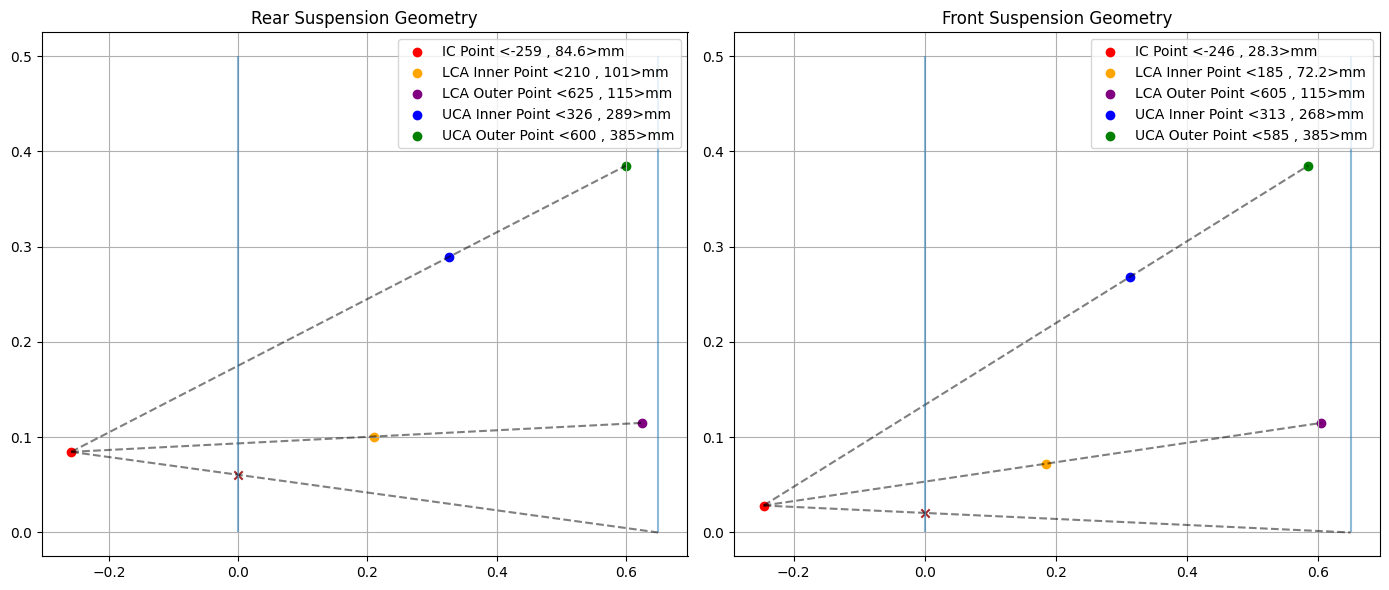

In [10]:
loaded_wheel_radius = 250e-3 #m
upright_vertical_spacing = 270e-3 #m
minimum_front_lca_centerline_distance = 185e-3 #m         This is the minimum distance from the LCA chassis pickup to the centerline in order to adhere to rules
minimum_rear_lca_centerline_distance = 210e-3 #m         This is the minimum distance from the LCA chassis pickup to the centerline in order to package the differential

#minimum_rear_lca_centerline_distance = minimum_front_lca_centerline_distance

#This is a wild guess at camber values [Probably too aggressive on camber gain]
rear_static_camber = np.radians(-1.5) #rads       
rear_target_camber = np.radians(-1.0) #rads

front_static_steer_camber = np.radians(-1.5) #rads
front_target_camber = np.radians(-1.0) #rads



def create_suspension_points(target_camber, initial_camber, roll_angle, roll_center_height, lca_horizontal_placement, lca_upright_offset, uca_upright_offset, uca_len_ratio):
    """Returns IC_point, lca_inner_point, lca_outer_point, uca_inner_point, uca_outer_point as np.arrays"""
    # Instantaneous Center point
    camber_change = target_camber - roll_angle - initial_camber
    IC_dist = (track_width/2)*np.tan(roll_angle)/np.tan(-camber_change) #TODO fix this equation
    IC_point = np.array([track_width/2 - IC_dist, IC_dist*roll_center_height/(track_width/2)])  #x,y

    #LCA
    lca_outer_point = np.array([track_width/2 - lca_upright_offset, loaded_wheel_radius - upright_vertical_spacing/2])
    lca_outer_to_ic = IC_point - lca_outer_point
    lca_inner_point = np.array([lca_horizontal_placement, lca_outer_point[1] + (lca_horizontal_placement-lca_outer_point[0]) * lca_outer_to_ic[1]/lca_outer_to_ic[0] ])

    #UCA
    uca_outer_point = np.array([track_width/2 - uca_upright_offset, loaded_wheel_radius + upright_vertical_spacing/2])
    uca_outer_to_ic = IC_point - uca_outer_point
    lca_len = np.sqrt(float((lca_inner_point[0]-lca_outer_point[0])**2 + (lca_inner_point[1]-lca_outer_point[1])**2))
    uca_inner_point = uca_outer_point + uca_len_ratio*lca_len * uca_outer_to_ic/np.sqrt(float((uca_outer_to_ic[0]**2 + uca_outer_to_ic[1]**2)))

    return IC_point, lca_inner_point, lca_outer_point, uca_inner_point, uca_outer_point


upright_pickup_offset = 50e-3 #m
kpi = np.radians(5) #rads

# ---REAR---
rear_roll_angle = roll_angles[phi_1_symb].subs([(chassis_stiffness_symb, chassis_stiffness),         
                                                (front_inertial_moment_symb, mass_front_symb*vehicle_params['maximum_lateral_acceleration'] * (vehicle_params['center_of_mass_height']-rear_roll_center_height)), 
                                                (rear_inertial_moment_symb, mass_rear_symb*vehicle_params['maximum_lateral_acceleration'] * (vehicle_params['center_of_mass_height']-front_roll_center_height)), 
                                                (mass_rear_symb, unsprung_mass*rear_mass_ratio),
                                                (mass_front_symb, unsprung_mass*(1-rear_mass_ratio)),
                                                (roll_stiffness_rear_symb, rear_roll_stiffness),
                                                (roll_stiffness_front_symb, front_roll_stiffness),
])

disp_md(f'The rear roll angle is **{rear_roll_angle*180/np.pi :.2f} deg**')
roll_center_angle = np.arctan(float(rear_roll_center_height/(track_width/2)))
disp_md(f'The rear roll center angle is **{roll_center_angle*180/np.pi :.2g} degrees**')
rear_points = create_suspension_points(rear_target_camber, rear_static_camber, float(rear_roll_angle), float(rear_roll_center_height), minimum_rear_lca_centerline_distance, 25e-3, 50e-3, 0.7)
rear_IC, rear_lca_inner_point, rear_lca_outer_point, rear_uca_inner_point, rear_uca_outer_point = rear_points

# ---FRONT---
front_roll_angle = roll_angles[phi_2_symb].subs([(chassis_stiffness_symb, chassis_stiffness),         
                                                (front_inertial_moment_symb, mass_front_symb*vehicle_params['maximum_lateral_acceleration'] * (vehicle_params['center_of_mass_height']-rear_roll_center_height)), 
                                                (rear_inertial_moment_symb, mass_rear_symb*vehicle_params['maximum_lateral_acceleration'] * (vehicle_params['center_of_mass_height']-front_roll_center_height)), 
                                                (mass_rear_symb, unsprung_mass*rear_mass_ratio),
                                                (mass_front_symb, unsprung_mass*(1-rear_mass_ratio)),
                                                (roll_stiffness_rear_symb, rear_roll_stiffness),
                                                (roll_stiffness_front_symb, front_roll_stiffness),
])

disp_md(f'The front roll angle is **{front_roll_angle*180/np.pi :.2f} deg**')
roll_center_angle = np.arctan(float(front_roll_center_height/(track_width/2)))
disp_md(f'The front roll center angle is **{roll_center_angle*180/np.pi :.2g} degrees**')
front_points = create_suspension_points(front_target_camber, front_static_steer_camber, float(front_roll_angle), float(front_roll_center_height), minimum_front_lca_centerline_distance, 45e-3, 65e-3, 0.7)
front_IC, front_lca_inner_point, front_lca_outer_point, front_uca_inner_point, front_uca_outer_point = front_points

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax_rear, ax_front = axes


# ---PLOTTING---
# REAR
ax = ax_rear
ax.plot([rear_IC[0], rear_uca_outer_point[0]], [rear_IC[1], rear_uca_outer_point[1]], color='black', linestyle='--', alpha=0.5)
ax.plot([rear_IC[0], rear_lca_outer_point[0]], [rear_IC[1], rear_lca_outer_point[1]], color='black', linestyle='--', alpha=0.5)
ax.plot([rear_IC[0], track_width/2], [rear_IC[1], 0], color='black', linestyle='--', alpha=0.5)


ax.scatter(*rear_IC, label=f'IC Point <{rear_IC[0]*1e+3 :.3g} , {rear_IC[1]*1e+3 :.3g}>mm', color='red')
ax.scatter(*rear_lca_inner_point, label=f'LCA Inner Point <{rear_lca_inner_point[0]*1e+3 :.3g} , {rear_lca_inner_point[1]*1e+3 :.3g}>mm', color='orange')
ax.scatter(*rear_lca_outer_point, label=f'LCA Outer Point <{rear_lca_outer_point[0]*1e+3 :.3g} , {rear_lca_outer_point[1]*1e+3 :.3g}>mm', color='purple')
ax.scatter(*rear_uca_inner_point, label=f'UCA Inner Point <{rear_uca_inner_point[0]*1e+3 :.3g} , {rear_uca_inner_point[1]*1e+3 :.3g}>mm', color='blue')
ax.scatter(*rear_uca_outer_point, label=f'UCA Outer Point <{rear_uca_outer_point[0]*1e+3 :.3g} , {rear_uca_outer_point[1]*1e+3 :.3g}>mm', color='green')
ax.scatter(0, rear_roll_center_height, color='brown', marker='x')
ax.vlines([0, track_width/2], 0, 0.5,  alpha=0.5)
ax.legend()
ax.grid()
ax.set_title('Rear Suspension Geometry')

# FRONT
ax = ax_front
ax.plot([front_IC[0], front_uca_outer_point[0]], [front_IC[1], front_uca_outer_point[1]], color='black', linestyle='--', alpha=0.5)
ax.plot([front_IC[0], front_lca_outer_point[0]], [front_IC[1], front_lca_outer_point[1]], color='black', linestyle='--', alpha=0.5)
ax.plot([front_IC[0], track_width/2], [front_IC[1], 0], color='black', linestyle='--', alpha=0.5)


ax.scatter(*front_IC, label=f'IC Point <{front_IC[0]*1e+3 :.3g} , {front_IC[1]*1e+3 :.3g}>mm', color='red')
ax.scatter(*front_lca_inner_point, label=f'LCA Inner Point <{front_lca_inner_point[0]*1e+3 :.3g} , {front_lca_inner_point[1]*1e+3 :.3g}>mm', color='orange')
ax.scatter(*front_lca_outer_point, label=f'LCA Outer Point <{front_lca_outer_point[0]*1e+3 :.3g} , {front_lca_outer_point[1]*1e+3 :.3g}>mm', color='purple')
ax.scatter(*front_uca_inner_point, label=f'UCA Inner Point <{front_uca_inner_point[0]*1e+3 :.3g} , {front_uca_inner_point[1]*1e+3 :.3g}>mm', color='blue')
ax.scatter(*front_uca_outer_point, label=f'UCA Outer Point <{front_uca_outer_point[0]*1e+3 :.3g} , {front_uca_outer_point[1]*1e+3 :.3g}>mm', color='green')
ax.scatter(0, front_roll_center_height, color='brown', marker='x')
ax.vlines([0, track_width/2], 0, 0.5, alpha=0.5)
ax.legend()
ax.grid()
ax.set_title('Front Suspension Geometry')

plt.tight_layout()
plt.show()
